In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd
import numpy as np
import csv
import random
from collections import Counter
from math import sqrt, e

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc = 0, scale = sensitivity/epsilon)
def pct_error(truth, priv):
    return np.abs(truth - priv)/truth*100
#encodes the response into a vector with binary entrances
def encode(response, domain):
    return [1 if d == response else 0 for d in domain]

# PSFO

In [34]:
# padding and sampling function
 #case cardinality of v is less than l adds l - |transaction| (dummy variables), dont belong to the items of transaction, so get random ones form the domain that dont belong to the transaction

 #then sample! That is: select AN element of trnasaction at a uniform random

#padds and samples, ,lol
def PS(l, transaction, domain):
    
    while len(transaction) < l:
        pool = [item for item in domain if item not in transaction]
        dummy = random.choice(pool)
        transaction.append(dummy)  #adds a dummy item from the domain pool
        #print(transaction)

    try:
        # Try to sample an item from the transaction
        sample = random.choice(transaction)
    except IndexError:
        # Catch error in case the transaction is empty or sampling fails
        print(f"Error: Could not sample from transaction. l = {l}, transaction = {transaction}, domain = {domain}")
    
    return sample

In [35]:
#Applies padding and sampling then an FO protocol
#To estimate the frequency of an item
#x, one obtains the frequency estimation of x from the FO
#protocol, and then multiplies it by l

#alsdo uses adaptive FO based on l and d

def PSFO(l, transactions, epsilon, domain):
    
    d = len(domain)

    #sum of total frequencies for preprocessing
    flattened_list = [item for sublist in transactions for item in sublist]
    item_counts = Counter(flattened_list)
    
    truth_total = sum(item_counts)
        
    #r = []
    r = np.zeros(d, dtype=int)
    
    #generates a list of size n, that is, n values, each coresponding to a padded and sampled transaction
    for transaction in transactions:
        #print("transaction",transaction)
        sample = PS(l, transaction, domain)
        #print("sample: ",sample)
        #r.append(sample)

        r += encode(sample, domain)

    #print("r :", r)
    #adaptive FO check
    if d < (l*(4*l - 1)*e**(epsilon) + 1):
        r_noise = DEresponses(r, epsilon)
    else:
        r_noise = OUEresponses(r, epsilon)

    
    #print("noise: ", r_noise)
    est = [item * l for item in r_noise]

    normsub_est = norm_sub(est, truth_total)
    
    return normsub_est 

# LDP

## OUE

In [36]:
def optimized_p_q(epsilon):
    p = 0.5
    q = 1/(e**epsilon + 1)

    return p, q

In [37]:
def OUEresponses(responses, epsilon):
    p, q = optimized_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p, q, n)  

In [38]:
def unary_epsilon(p, q):
    return np.log(p*(1-q)/((1-p)*q))

In [39]:
def symetric_p_q(epsilon):
    p = (e**(epsilon/2)) / (e**(epsilon/2) + 1)
    q = 1 / (e**(epsilon/2) + 1)

    return p, q

In [40]:
def perturb_onto_agg(responses, p , q):
    noisy_responses = np.zeros(len(responses))
    #print("SOMA: ",sum(responses))
    
    for i in range(len(responses)):
        #print("i",i)
        for j in range(responses[i]):
            #print("j",j)
            for k in range(len(noisy_responses)):
                #print("k",k)
                #works hence the internal for iterates each one time for a singular unit
                sample = np.random.random()
                
                #case bit is 1(same cell, therefore using p)
                if i == k:
                    #print("here")
                    if sample <= p:
                        #tell the turht
                        #by adding 1 to the i(k) position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else:
                        #lie
                        #by not adding anything to the vector
                #handles other cells(using q probability)
                else:
                    #print("there")
                    if sample <= q:
                        #lie
                        #by summing 1 onto the k position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else: 
                        #truth
                        #by omiting form it
    return noisy_responses

In [41]:
def adjustUE(noisy_responses, p, q, n):
    d = len(noisy_responses)
    copyUE = noisy_responses.copy().astype(int)
    
    for i in range(len(copyUE)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copyUE[i] = a * copyUE[i] - b

    return copyUE

In [42]:
def UEresponses(responses, epsilon):
    p, q = symetric_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p ,q, n)

In [43]:
def norm_sub(estimations, truth_total):
    f_tilde = np.array(estimations, dtype=float)  # Convert to a numpy array
    
    # Convert negative values to 0
    f_tilde[f_tilde < 0] = 0

    # Normalize f_tilde to sum to 1
    f_tilde /= f_tilde.sum()

    # Scale it back to the original total
    scaled_values = f_tilde * truth_total

    # Convert to integers and calculate the difference
    int_values = np.floor(scaled_values).astype(int)
    difference = truth_total - np.sum(int_values)

    # Distribute the remaining difference by adding 1 to some of the elements
    indices = np.argsort(scaled_values - int_values)[-difference:]  # Get the indices with the largest fractional part
    int_values[indices] += 1

    return int_values

## DE

In [44]:
def DE_p_q(epsilon, d):
    p = (e**epsilon) / (e**epsilon + d - 1)

    q = (1 - p) / (d - 1)

    return p, q

In [45]:
#case de mehcanism decides the response to be fake, ramdomly picks all the values but the truthful response of the domain
def random_pick_DE(domain, response):
    domain_q = [i for i in domain if i != response]
    return random.choice(domain_q)

In [46]:
def randomized_responses_DE(responses, epsilon):
    d = len(responses)
    domain = [i for i in range(0, d)]
    p, q = DE_p_q(epsilon, d)

    noisy_responses = np.zeros(len(responses))

    for i in range(len(responses)):
        for j in range(responses[i]):
            sample = np.random.random()

            if sample <= p:
                #tell the truth
                #by adding to noisy_responses in the i position
                noisy_responses[i] = noisy_responses[i] + 1

            else:
                #lie
                #by adding to noisy_responses in any position but i 
                any_pos_but_i = random_pick_DE(domain, i)
                noisy_responses[any_pos_but_i] = noisy_responses[any_pos_but_i] + 1

    return noisy_responses

In [47]:
def adjustDE(noisy_responses, epsilon, n):
    d = len(noisy_responses)
    p, q = DE_p_q(epsilon, d)
    copy = noisy_responses.copy().astype(int)
    
    for i in range(len(copy)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copy[i] = a * copy[i] - b

    return copy

In [48]:
def DEresponses(responses, epsilon):
    n = sum(responses)
    return adjustDE(randomized_responses_DE(responses, epsilon), epsilon, n)

# Score based Study

In [49]:
#here the scores are defined by the count of the item
def score(data, domain):

        # Convert data to a pandas Series if it's a numpy array
    if isinstance(data, np.ndarray):
        data = pd.Series(data)

    return data.value_counts()[domain]/1000

In [50]:
#likewise, here the scores prioritaze smaller values
def score2(data, domain):
    return 1/data.value_counts()[domain]

In [51]:
domain = adult['Marital Status'].unique()

In [52]:
domain

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [53]:
score(adult['Marital Status'], 'Never-married')

10.684

In [54]:
score(adult['Marital Status'], 'Divorced')

4.443

In [55]:
score(adult['Marital Status'], 'Married-civ-spouse')

14.977

In [56]:
score(adult['Marital Status'], 'Married-AF-spouse')

0.023

In [57]:
counts = adult['Marital Status'].value_counts()
print(counts)

Marital Status
Married-civ-spouse       14977
Never-married            10684
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64


In [58]:
print(options)

NameError: name 'options' is not defined

In [59]:
def exponential(x, R, u, sensitivity, epsilon):

    if isinstance(R, set):
        R = list(R)
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]
    #print(scores)
    # Calculate the probability for each element, based on its score
    probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in scores]
    #print(probabilities)
    # Normalize the probabilties so they sum to 1
    probabilities = probabilities / np.linalg.norm(probabilities, ord=1)
    print(probabilities)
    # Choose an element from R based on the probabilities
    return np.random.choice(R, 1, p=probabilities)[0]

In [60]:
r = exponential(adult['Marital Status'], options, score, 1, 1)
r

NameError: name 'options' is not defined

In [61]:
r = [exponential(adult['Marital Status'], options, score, 1, 1) for i in range(200)]
pd.Series(r).value_counts()

NameError: name 'options' is not defined

In [62]:
def report_noisy_max(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]

    # Add noise to each score
    noisy_scores = [laplace_mech(score, sensitivity, epsilon) for score in scores]

    # Find the index of the maximum score
    max_idx = np.argmax(noisy_scores)
    
    # Return the element corresponding to that index
    return R[max_idx]

report_noisy_max(adult['Marital Status'], options, score, 1, 1)

NameError: name 'options' is not defined

In [63]:
r = [report_noisy_max(adult['Marital Status'], options, score, 1, 1) for i in range(200)]
pd.Series(r).value_counts()

NameError: name 'options' is not defined

# Sensitivity Study

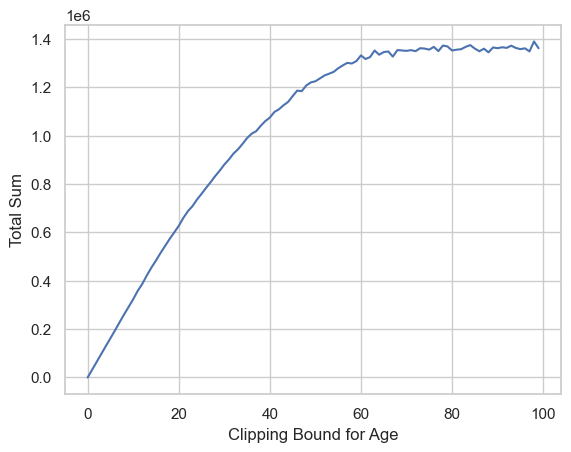

In [64]:
epsilon_i = .01
plt.plot([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)])
plt.xlabel('Clipping Bound for Age')
plt.ylabel('Total Sum');

No interval of stability found


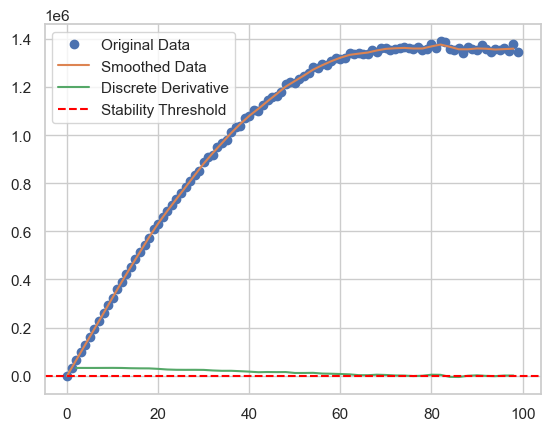

In [72]:
import matplotlib.pyplot as plt
import csaps
import numpy as np

# Generate the data
data = np.array([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, 0.01) for i in range(100)])

# Define x and y for spline fitting
x_data = np.arange(len(data))  # x-axis values corresponding to data points
y_data = data  # y-axis data

# Apply cubic smoothing spline with adjusted smoothing factor
step = 2  # Adjusted step size
xs = np.arange(0, len(data), step=step)
ys = csaps.csaps(x_data, y_data, xs, smooth=0.3)  # Adjusted smoothing factor

# Calculate discrete derivative of the smoothed data
der = [(ys[i] - ys[i - 1]) / step for i in range(1, len(xs))]

# Adjusted moving window and epsilon tolerance
window_size = 10  # Adjusted window size
window_size_s = int(window_size / step)
epsilon = 0.3  # Adjusted tolerance

# Find stable intervals within tolerance
stable = [i for i in range(1, len(xs) - window_size_s) if np.max(np.abs(der[i:i + window_size_s])) < epsilon]
if len(stable) > 3:
    stable_start = stable[0] * step
    stable_end = stable[-1] * step + window_size
    print(f"Stability from {stable_start} to {stable_end}")
else:
    print("No interval of stability found")

# Plot the results
fig, ax = plt.subplots()
plt.plot(x_data, y_data, 'o', label='Original Data')
plt.plot(xs, ys, '-', label='Smoothed Data')
plt.plot(xs[1:], der, '-', label='Discrete Derivative')
plt.axhline(epsilon, color='red', linestyle='--', label='Stability Threshold')
plt.legend()
plt.show()


[32731.07005425 32436.52653961 33507.9261498  31263.51752276
 32558.95838872 32506.57107891 32726.83334287 31865.84802522
 32954.86811283 30411.59833368 35011.05450719 35359.25560931
 24979.32804013 36732.25231849 27704.65662696 29671.05699767
 30413.66632486 32345.92964744 22444.81392527 29613.56056046
 26803.81418815 32233.85019806 23428.81523257 27961.9041809
 25471.94159335 23454.76014815 31477.76269648 15707.74151095
 23396.49833816 24249.5941907  21197.34801426 18983.98349661
 21174.08301914 22445.2802282  23121.65166259 15348.196459
 29154.58294474  7571.96285083 21068.14349785 22339.9482562
 11548.35030096 13224.71243114 24275.63186854  8408.73347086
 17397.40747099 10500.26456547 24875.74255589  9858.13292323
  8171.03686066 29430.47781249  9166.78049822 24343.99775652
  1385.04539662 12934.44437371  2018.29423139 24625.38404416
 17355.94945448 20539.30291462  6827.98609054 13149.52502081
 25784.25806762 12347.50552114 21166.98817909  9239.45265191
  3022.13851304 22509.124763

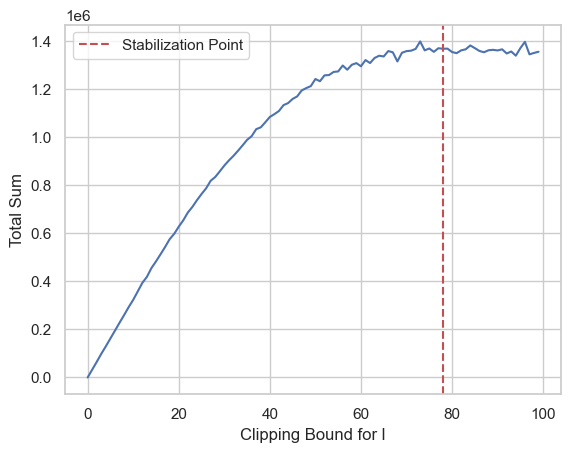

Stabilization point at index: 78


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate data
epsilon_i = 0.01
data = np.array([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)])

# Plot the data
plt.plot(data)
plt.xlabel('Clipping Bound for l')
plt.ylabel('Total Sum')

# Calculate differences between consecutive values
differences = np.abs(np.diff(data))
print(differences)

# Define a stability threshold
threshold = 1000

# Find the stabilization point
stabilization_point = np.argmax(differences < threshold) 

# Plot the stabilization point
plt.axvline(x=stabilization_point, color='r', linestyle='--', label='Stabilization Point')
plt.legend()
plt.show()

print("Stabilization point at index:", stabilization_point)


In [114]:
def reconstruct_cardinalities(r):
    return np.hstack([np.full(count, idx) for idx, count in enumerate(r)])

In [128]:
l_freq = [325, 780, 560, 789, 340, 60, 20 , 3, 1, 0]

In [129]:
est_ls = reconstruct_cardinalities(l_freq)
est_ls

array([0, 0, 0, ..., 7, 7, 8])

In [130]:
est_ls = np.array(est_ls)
est_ls

array([0, 0, 0, ..., 7, 7, 8])

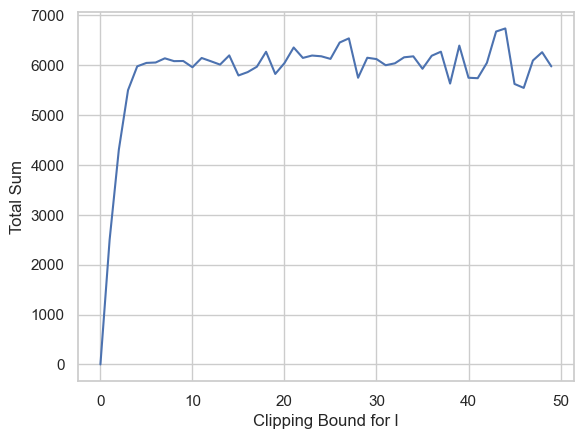

In [145]:
epsilon_i = .1
plt.plot([laplace_mech(est_ls.clip(0, i).sum(), i, epsilon_i) for i in range(50)])
plt.xlabel('Clipping Bound for l')
plt.ylabel('Total Sum');

In [147]:
#divide avaraging queries into sum and count querries
sum_of_ls = laplace_mech(est_ls.clip(0, 10).sum(), 10, 1)
sum_of_ls

6081.3863885633955

In [148]:
print(sum(est_ls))

6076


In [149]:
count_of_ls = laplace_mech(len(est_ls), 1, 1)
count_of_ls

2877.7591914626228

In [151]:
print(len(est_ls))

2878


# test w data

In [195]:
#as a list
user_transactions_BMS = []

with open('BMS-POS.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        user_transactions_BMS.append([int(item) for item in row if item])

for idx, transaction in enumerate(user_transactions_BMS, start=0):
    print(transaction)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 3, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[1, 3, 8, 11, 35, 59, 60, 61, 62, 63]
[1, 3, 8, 28, 35, 59, 64, 65, 66, 67, 68, 69]
[11, 30, 62, 70, 71, 72, 73]
[3, 9, 33, 42, 72, 74, 75]
[8, 72, 76]
[2, 9, 26, 30, 35, 53, 61, 72, 77]
[72, 78]
[3, 24, 33, 72, 79]
[3, 9, 30, 42, 65, 80, 81]
[3, 9, 10, 35, 42, 43, 72, 74, 82, 83, 84]
[8, 9, 11, 33, 35, 36, 37, 61, 74, 85, 86, 87, 88]
[3, 10, 28, 35, 36, 63, 72, 89]
[1, 3, 9, 10, 33, 42, 53, 62, 72, 74, 81, 90, 91, 92, 93]
[3, 8, 9, 30, 37, 42, 47, 59, 74, 81, 94, 95, 96]
[33, 34, 37, 65, 72, 95]
[1, 3, 9, 11, 16, 18, 30, 42, 59, 65, 78, 86, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]
[3, 14, 30, 37, 74, 86, 92, 106]
[1, 3, 9, 30, 34, 35, 55, 60, 94, 107, 108]
[8, 10, 11, 15, 109, 110]
[3, 23, 30, 65, 91, 92, 111, 112, 113, 114, 115, 116, 1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [196]:
total_users = len(user_transactions_BMS)
print(total_users)

item_group_size = int(total_users * 0.5) #50%

group_1_size = int(item_group_size * 0.5)  # 50% of %50
group_2_size = int(item_group_size * 0.1)  # 10% of %50
group_3_size = int(item_group_size * 0.4)  # 40% of %50

#shuffle list
random.seed(42)  # For reproducibility
shuffled_data = user_transactions_BMS.copy()
random.shuffle(shuffled_data)

#groups
group_1 = shuffled_data[:group_1_size]  # 50%
group_2 = shuffled_data[group_1_size:group_1_size + group_2_size]  # 10%
group_3 = shuffled_data[group_1_size + group_2_size:group_1_size + group_2_size + group_3_size]  # 40%

print(f"group 1 size: {len(group_1)}")
print(f"group 2 size: {len(group_2)}")
print(f"group 3 size: {len(group_3)}")
print(f"total size: {len(group_1) + len(group_2) + len(group_3)}")

515596
group 1 size: 128899
group 2 size: 25779
group 3 size: 103119
total size: 257797


In [197]:
domain = set(item for transaction in user_transactions_BMS for item in transaction)
print(domain)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [198]:
S = [3, 35, 8, 9, 33, 30, 1, 10, 37, 63, 36, 81, 34, 42, 172, 11, 23, 139, 60, 65]

In [199]:
def reconstruct_cardinalities(r):
    return np.hstack([np.full(count, idx) for idx, count in enumerate(r)])

In [200]:
def get_intersections_cardinalities(S, transactions, epsilon):
    
    intersection_cardinalities = []
    r = np.zeros(len(S) + 1, dtype=int)

    for transaction in transactions:
        intersection_cardinality = sum(item in S for item in transaction)
        intersection_cardinalities.append(intersection_cardinality)

    domain = list(range(0, len(S)+1))
    
    for cardinality in intersection_cardinalities:
        r += encode(cardinality, domain)

    r_noise = OUEresponses(r, epsilon)
    #print(intersection_cardinalities)
    return r

In [201]:
def Candidates_SVIM(k, transactions, epsilon, domain):
    
    l = 1
    r = PSFO(l, transactions, epsilon, domain)

    #top values 
    top_2k_values = np.sort(np.unique(r))[-2*k:][::-1]
    top_2k_indices = [np.where(r == value)[0] for value in top_2k_values]
    
    S = [int(arr[0]) if not isinstance(arr, int) else arr for arr in top_2k_indices]

    return S

In [207]:
def L_SVIM(S, percentile, transactions, epsilon):

    r = get_intersections_cardinalities(S, transactions, epsilon)
    estimated_cardinalities = reconstruct_cardinalities(r)

    L = np.percentile(estimated_cardinalities, percentile)

    if L == 0:
        L = 1

    return estimated_cardinalities

In [205]:
S = Candidates_SVIM(10, group_1, 5, domain)

In [206]:
print(S)

[3, 35, 8, 9, 33, 30, 1, 10, 37, 63, 34, 81, 36, 42, 11, 172, 65, 241, 23, 139]


In [208]:
estimated_cardinalities = L_SVIM(S, 90, group_2, 5)

In [209]:
estimated_cardinalities

array([ 0,  0,  0, ..., 16, 17, 17])

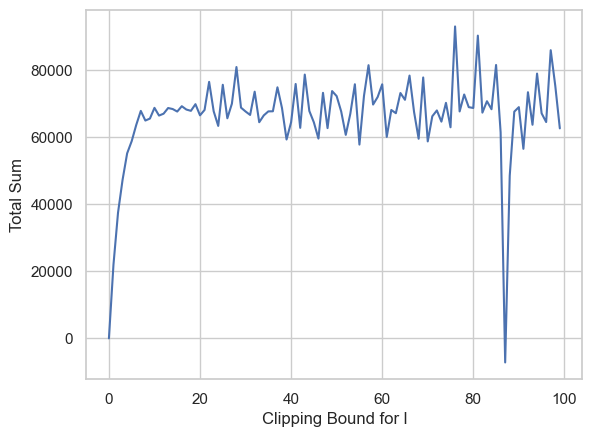

In [213]:
epsilon_i = .01
plt.plot([laplace_mech(estimated_cardinalities.clip(0, i).sum(), i, epsilon_i) for i in range(100)])
plt.xlabel('Clipping Bound for l')
plt.ylabel('Total Sum');

In [214]:
#divide avaraging queries into sum and count querries
sum_of_ls = laplace_mech(estimated_cardinalities.clip(0, 20).sum(), 20, 1)
sum_of_ls

67293.45549160514

In [216]:
print(sum(estimated_cardinalities))

67334


In [217]:
count_of_ls = laplace_mech(len(estimated_cardinalities), 1, 1)
count_of_ls

25780.642983408092

In [218]:
print(len(estimated_cardinalities))

25779


In [219]:
print(len(group_2))

25779


In [220]:
print(sum_of_ls/count_of_ls)

2.610231852437267


In [227]:
mean = np.mean(estimated_cardinalities)
mean

2.611970984134373

In [228]:
L_90 = np.percentile(estimated_cardinalities, 90)
L_90

6.0

In [229]:
domain_l = set(estimated_cardinalities)
domain_l

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [305]:
def score_max(data, item):
    return item

In [306]:
data = [7, 1, 1, 2, 4, 2, 7]
item = [7]

score(data, item)

[7]

In [307]:
r = exponential(estimated_cardinalities, domain_l, score_max, 1, 1)
r

[8.00684462e-05 1.32010550e-04 2.17648602e-04 3.58841880e-04
 5.91630240e-04 9.75433362e-04 1.60821773e-03 2.65150278e-03
 4.37158904e-03 7.20753183e-03 1.18832110e-02 1.95921028e-02
 3.23019166e-02 5.32568570e-02 8.78057130e-02 1.44767147e-01
 2.38680674e-01 3.93517904e-01]


15